In [1]:
!date

Tue Jul  9 13:10:09 PDT 2024


In [2]:
!echo $CONDA_PREFIX

/c4/home/derek/miniconda3/envs/scquint_4


In [2]:
import os

import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from scquint.data import load_adata_from_starsolo, add_gene_annotation, group_introns

from scquint.data import calculate_PSI

In [4]:
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import pandas

In [6]:
[i for i in os.listdir('/c4/home/derek/data1/derek/data_scSLR/PBMC/') if i.endswith('h5ad')]

['gene_expression.h5ad',
 'spl_3prime_splice_acceptor.h5ad',
 '5prime_spl_3prime_splice_acceptor.h5ad',
 '5prime_exp_h5ad',
 'concat.3.new.h5ad',
 'adata_spl_v2.h5ad',
 'adata_spl_v1.h5ad',
 '5prime_spl_3prime_spl_acceptor.h5ad',
 '5prime_adata_spl_v2.h5ad',
 'adata_spl_1_v3.h5ad',
 'gene_expression_v2.h5ad',
 'adata_spl_orig_sample_2.h5ad',
 'adata_spl_new_sample_2.h5ad',
 'adata_spl_merged_shared.h5ad',
 '_adata_spl_merged_shared.h5ad']

In [6]:
#adata_SLR = sc.read_h5ad('/c4/home/derek/data1/derek/data_scSLR/PBMC/5prime_spl_3prime_spl_acceptor.h5ad')

adata_SLR = sc.read_h5ad('/c4/home/derek/data1/derek/data_scSLR/PBMC/adata_spl_new_sample_2.h5ad')



In [7]:
adata_SS3 = sc.read_h5ad('/c4/home/derek/data1/derek/data_scSLR/reference/SS3_PBMC/_SS3_5prime_spl_3prime_spl_acceptor.h5ad')

In [8]:
# Here's a scatter plot of mean PSI where each point corresponds to an intron,cell_type pair, and the x-axis could be mean PSI in 
# SMARTseq and y-axis in SLR. The introns are those appear in both SMARTseq and SLR data. To make sure the mean of PSI are representative, we only
# plot the introns with PSI is defined in more than n=10 cells of thecell cluster. The Pearson correlation here is 0.926. This shows that for matched introns in both datasets, 
# mean PSIs of intron in each cell type cluster in one dataset are al so highly correlated with another.

In [9]:
adata_SLR.layers["PSI_raw"] = calculate_PSI(adata_SLR)

adata_SS3.layers["PSI_raw"] = calculate_PSI(adata_SS3)


/c4/home/derek/bin/scquint/scquint/data.py:212: RuntimeWarning: invalid value encountered in divide
  return X / intron_group_sums[:,groups]


In [10]:
##rename SS3 celltype annotations

In [11]:
adata_SS3 = adata_SS3[~adata_SS3.obs.celltype.isin(['HEK','HEK cells'])]

In [12]:
celltype_dict ={'CD14 monocytes':'cM',
 'Cytotoxic T':'T8',
 'Cytotoxic T cells':'T8',
 'Dendritic cells':'cDC',
 'Effector CD4 T':'T4',
 'FCGR3A NK cells':'NK',
 'FCGR3A monocytes':'ncM',
 'Memory B':'B',
 'NK cells':'NK',   
 'Naive B':'B',
 'Naive/Memory CD4 T':'T4',
 'Naive/Memory CD8 T':'T8',
 'Plasma cells':'PB',
 'Senescent CD4 T':'T4',
 'plasmacytoid DC':'pDC'
}

In [13]:
adata_SS3.obs['ct1'] = adata_SS3.obs.celltype.map(celltype_dict)

/scratch/derek/ipykernel_2812473/2806265984.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_SS3.obs['ct1'] = adata_SS3.obs.celltype.map(celltype_dict)


In [14]:
marker_genes = adata_SLR.var.index.intersection(adata_SS3.var.index).tolist()

genedf_SLR = sc.get.obs_df(
        adata_SLR,
        keys=["ct1", *marker_genes],
    layer='PSI_raw'
)
    
    


In [15]:
df_SLR=pd.Series()

for celltype in genedf_SLR.ct1.unique():
    
    genedf_SLR_ = genedf_SLR[genedf_SLR.ct1 == celltype]
    
    genedf_SLR_.dropna(thresh = 20,
                 axis=1,inplace=True)

    means = genedf_SLR_.mean(axis=0)
    
   # means.name = celltype
    means.index = means.index.astype(str) + '_' + celltype
    
    df_SLR = df_SLR.append(means,
                  # ignore_index=True
                  )
    

In [16]:
# marker_genes = adata_SLR.var.index.intersection(adata_SS3.var.index).tolist()

genedf_SS3 = sc.get.obs_df(
        adata_SS3,
        keys=["ct1", *marker_genes],
    layer='PSI_raw'
)

In [17]:
df_SS3=pd.Series()

for celltype in genedf_SS3.ct1.unique():
    
    genedf_SS3_ = genedf_SS3[genedf_SS3.ct1 == celltype]
    
    genedf_SS3_.dropna(thresh = 20,
                 axis=1,inplace=True)

    means = genedf_SS3_.mean(axis=0)
    
    #means.name = celltype
    means.index = means.index.astype(str) + '_' + celltype
    
    df_SS3 = df_SS3.append(means,
                  # ignore_index=True
                  )
    

In [18]:
df_SS3 = df_SS3[df_SS3.index.isin(df_SLR.index)]

In [19]:
df_SLR = df_SLR[df_SLR.index.isin(df_SS3.index)]

In [20]:
corr = df_SLR.corr(df_SS3,method = 'pearson')

In [21]:
df_SS3

LINC01128_chr1:829105-841199_T4        0.275862
LINC01128_chr1:829105-847653_T4        0.724138
LINC01128_chr1:829105-851926_T4        0.474576
UBE2J2_chr1:1257311-1263345_T4         0.970588
UBE2J2_chr1:1263387-1273665_T4         0.099010
                                         ...   
NDUFA1_chrX:119875468-119876513_cDC    0.000000
SSR4_chrX:153797533-153797724_cDC      1.000000
RPL10_chrX:154398395-154398496_cDC     0.975516
RPL10_chrX:154398399-154398496_cDC     0.024484
RPL10_chrX:154398543-154399337_cDC     1.000000
Length: 44112, dtype: float64

In [22]:
df_SLR

RPL11_chr1:23692760-23693806_cM        0.998229
RPL11_chr1:23692760-23693810_cM        0.000636
RPL11_chr1:23693914-23695797_cM        0.001512
SH3BGRL3_chr1:26280933-26281028_cM     0.001541
SH3BGRL3_chr1:26280933-26281057_cM     0.998459
                                         ...   
NDUFA1_chrX:119875468-119876513_cDC    0.000000
SSR4_chrX:153797533-153797724_cDC      1.000000
RPL10_chrX:154398395-154398496_cDC     0.989947
RPL10_chrX:154398399-154398496_cDC     0.010053
RPL10_chrX:154398543-154399337_cDC     0.999559
Length: 44112, dtype: float64

Text(0, 0.5, 'Ψ scSLR-seq')

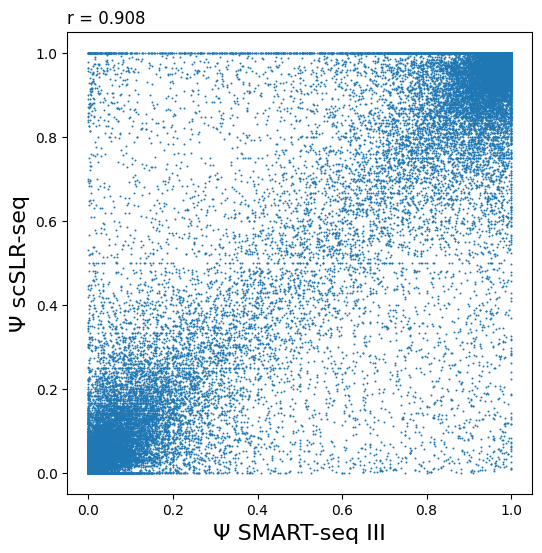

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(x=df_SS3,
                y=df_SLR,
                s=2,
                linewidth=0,
                ax=ax
                
               )

# ax.spines.right.set_visible(False)
# ax.spines.top.set_visible(False)

ax.set_title(f'r = {round(corr,3)}',loc='left')

ax.set_xlabel('Ψ SMART-seq III', fontsize=16)
ax.set_ylabel('Ψ scSLR-seq', fontsize=16)



# sns.kdeplot(
#     data=tips,
#     x=df_SS3,
#     y=df,
#     levels=10,
#     fill=True,
#     alpha=1,#0.6,
#     cut=0,
#     ax=ax,
#    # clip
# )

In [24]:
data = pd.concat([df_SS3,df_SLR],axis=1)

In [25]:
data.columns = ['SS2','SLR']

Text(0.5, 0, 'Ψ scSLR-seq')

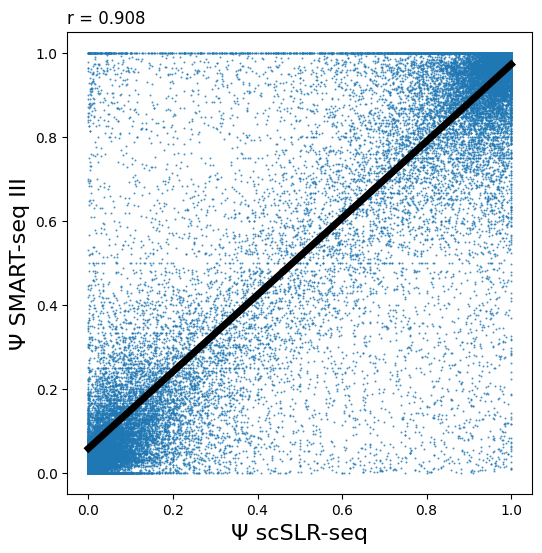

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.regplot(data = data,
            x='SS2',
            y='SLR',
            scatter_kws={'s':2, 'linewidth':0},
            line_kws={"lw":5, 'color':'black'},
            ax=ax
                
               )

# ax.spines.right.set_visible(False)
# ax.spines.top.set_visible(False)

ax.set_title(f'r = {round(corr,3)}',loc='left')

ax.set_ylabel('Ψ SMART-seq III', fontsize=16)
ax.set_xlabel('Ψ scSLR-seq', fontsize=16)



In [27]:
0.841
0.951

0.951

In [28]:
from scipy import stats

In [29]:
values = np.vstack([df_SS3, df_SLR])

In [30]:
kernel = stats.gaussian_kde(values)(values)

In [31]:
idx = kernel.argsort()
x, y, z = df_SLR[idx], df_SS3[idx], kernel[idx]

In [32]:
kernel.argsort()

array([27581,  8702, 24851, ..., 28576, 39558, 19156])

In [33]:
kernel

array([0.67463745, 0.58130476, 0.34942889, ..., 4.4860424 , 3.06805587,
       4.02585503])

In [34]:
df_SLR  #.reindex(idx)

RPL11_chr1:23692760-23693806_cM        0.998229
RPL11_chr1:23692760-23693810_cM        0.000636
RPL11_chr1:23693914-23695797_cM        0.001512
SH3BGRL3_chr1:26280933-26281028_cM     0.001541
SH3BGRL3_chr1:26280933-26281057_cM     0.998459
                                         ...   
NDUFA1_chrX:119875468-119876513_cDC    0.000000
SSR4_chrX:153797533-153797724_cDC      1.000000
RPL10_chrX:154398395-154398496_cDC     0.989947
RPL10_chrX:154398399-154398496_cDC     0.010053
RPL10_chrX:154398543-154399337_cDC     0.999559
Length: 44112, dtype: float64

Text(0.5, 0, 'Ψ scSLR-seq')

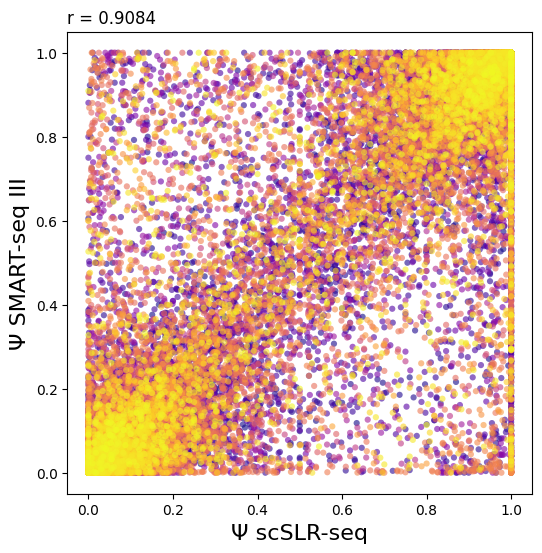

In [35]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(
    x=x,
    y=y,
    c=z,
    s=20,
    cmap="plasma",
    ax=ax,
    linewidth=0,
    alpha=.6
)

# ax.spines.right.set_visible(False)
# ax.spines.top.set_visible(False)

# ax.spines.bottom.set_linewidth(2)
# ax.spines.left.set_linewidth(2)


ax.set_title(f"r = {round(corr,4)}",loc='left')

ax.set_ylabel('Ψ SMART-seq III', fontsize=16)
ax.set_xlabel('Ψ scSLR-seq', fontsize=16)

#fig.savefig('SLR_SS3_PBMC.pdf')

In [36]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

/scratch/derek/ipykernel_2812473/3729453523.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('bone_r', 1024)


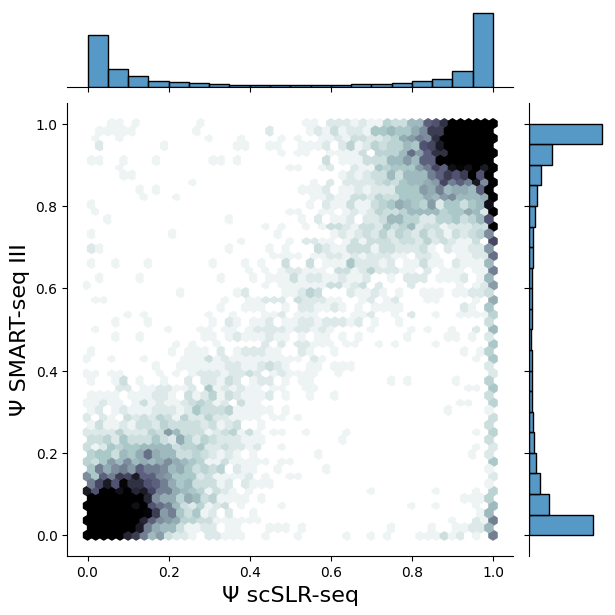

In [37]:
cmap = cm.get_cmap('bone_r', 1024)
newcmp = ListedColormap(cmap(np.linspace(0, 50, 1024)))

h=sns.jointplot(x=x, y=y,
              #kind="hex", 
              #color="#4CB391",
              kind='hex', 
              cmap= newcmp,
              joint_kws=dict(gridsize=50),
             )

#h.ax_marg_x()
h.set_axis_labels(xlabel='Ψ scSLR-seq', ylabel='Ψ SMART-seq III', fontsize=16)

#h.savefig('./plots/PSI_correlation_hexbin.pdf')

# plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
# # make new ax object for the cbar
# cbar_ax = h.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
# plt.colorbar(cax=cbar_ax)
# plt.show()


In [38]:
from scquint.differential_splicing import find_marker_introns

/c4/home/derek/miniconda3/envs/scquint_4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
sig_diff_spl_intron_groups = pd.read_csv("/c4/home/derek/data1/derek/data_scSLR/PBMC/diff_intron_groups_SLR")

sig_diff_spl_introns = pd.read_csv("/c4/home/derek/data1/derek/data_scSLR/PBMC/diff_introns_SLR")

In [40]:
#fixing test_group naming if need be
sig_diff_spl_introns.test_group.unique() #.map(celltype_dict)

array(['Classic monocytes', 'Memory CD4 T cells', 'Naïve CD4 T cells',
       'Memory CD8 T cells', 'B cells', 'NK cells',
       'Non-classic monocytes', 'Naive CD8 T cells'], dtype=object)

In [41]:
celltype_dict

{'CD14 monocytes': 'cM',
 'Cytotoxic T': 'T8',
 'Cytotoxic T cells': 'T8',
 'Dendritic cells': 'cDC',
 'Effector CD4 T': 'T4',
 'FCGR3A NK cells': 'NK',
 'FCGR3A monocytes': 'ncM',
 'Memory B': 'B',
 'NK cells': 'NK',
 'Naive B': 'B',
 'Naive/Memory CD4 T': 'T4',
 'Naive/Memory CD8 T': 'T8',
 'Plasma cells': 'PB',
 'Senescent CD4 T': 'T4',
 'plasmacytoid DC': 'pDC'}

In [42]:
input_dir = output_dir= '/c4/home/derek/data1/derek/data_scSLR/PBMC/'
adata_exp = sc.read_h5ad(input_dir+'gene_expression.h5ad')

In [43]:
adata_SLR = adata_SLR[:,adata_SLR.var['gene_name'].isin(adata_exp.var_names)]

In [44]:
adata_exp.var_names_make_unique()

sc.pp.normalize_total(adata_exp, target_sum=1e6)
sc.pp.log1p(adata_exp)

In [45]:
marker_introns = find_marker_introns(
    sig_diff_spl_intron_groups, sig_diff_spl_introns, 5000, 
    max_p_value_adj=0.05,
    min_delta_psi=0,
)

In [46]:
temp=[]

for key in marker_introns.keys():
    genes = marker_introns[key]
    count = len(genes)
    print(count)
    temp.append(count)
    
sum(temp)

94
533
26
49
25
15
72
17


831

In [47]:
marker_introns.keys()

dict_keys(['B cells', 'Classic monocytes', 'NK cells', 'Non-classic monocytes', 'Memory CD4 T cells', 'Memory CD8 T cells', 'Naïve CD4 T cells', 'Naive CD8 T cells'])

In [48]:
introns = marker_introns['Classic monocytes']

In [49]:
adata_SLR.var_names

Index(['HES4_chr1:999614-999865', 'HES4_chr1:999788-999865',
       'SDF4_chr1:1217689-1218457', 'SDF4_chr1:1217805-1218457',
       'UBE2J2_chr1:1257311-1263345', 'UBE2J2_chr1:1262391-1263345',
       'UBE2J2_chr1:1263387-1273665', 'UBE2J2_chr1:1267993-1273665',
       'INTS11_chr1:1319434-1320455', 'INTS11_chr1:1319525-1320455',
       ...
       'UTY_chrY:13326351-13335562', 'UTY_chrY:13336336-13354785',
       'UTY_chrY:13359987-13360429', 'UTY_chrY:13369350-13393858',
       'UTY_chrY:13396973-13399937', 'UTY_chrY:13396973-13403782',
       'KDM5D_chrY:19735751-19739527', 'EIF1AY_chrY:20579419-20579607',
       'EIF1AY_chrY:20582601-20584473', 'EIF1AY_chrY:20584525-20588023'],
      dtype='object', length=52799)

In [50]:
introns = [i for i in introns if i in adata_SLR.var_names]

In [51]:
spec_SLR = sc.get.obs_df(
        adata_SLR,
        keys=["ct1", *introns],
        layer='PSI_raw')

In [52]:
spec_SLR = spec_SLR[spec_SLR["ct1"] == 'cM'].mean(numeric_only=True)

In [53]:
spec_SLR

CPNE2_chr16:57127904-57134774      0.933333
METTL8_chr2:171360514-171414602    0.714286
LPAR2_chr19:19627285-19627396      0.666667
ADCY7_chr16:50274199-50287911      1.000000
HOPX_chr4:56656013-56681254        0.290909
                                     ...   
PFN1_chr17:4945998-4948262         0.006577
CYBA_chr16:88648115-88650955       0.999718
RPL32_chr3:12840342-12841493       0.017141
HLA-A_chr6:29942627-29944121       0.002817
RPS14_chr5:150446964-150447584     0.994836
Length: 490, dtype: float64

In [54]:
adata_SLR.obs.ct1

barcode_index
AAACCTGAGAGTACAT-1-23     cM
AAACCTGAGAGTGACC-1-23      B
AAACCTGAGATGTTAG-1-23     cM
AAACCTGAGCAGCCTC-1-23     T8
AAACCTGAGCGTTCCG-1-23     T8
                        ... 
TTTGTCAGTGTTGAGG-1-23     T4
TTTGTCAGTTGGACCC-1-23    ncM
TTTGTCAGTTGTACAC-1-23     T8
TTTGTCATCCGGGTGT-1-23    Tgd
TTTGTCATCTACTATC-1-23     cM
Name: ct1, Length: 10173, dtype: category
Categories (11, object): ['B', 'NK', 'PB', 'Progen', ..., 'cDC', 'cM', 'ncM', 'pDC']

In [55]:
SLR = pd.DataFrame()
EXP = pd.DataFrame()


for key in marker_introns.keys():
    
    introns = marker_introns[key]
    introns = [i for i in introns if i in adata_SLR.var_names]
    
    spec_SLR = sc.get.obs_df(
        adata_SLR,
        keys=["ct1", *introns],
        layer='PSI_raw')
    
    spec_SLR = spec_SLR[spec_SLR["ct1"] == key].mean(numeric_only=True)
    
    SLR = pd.concat([SLR,spec_SLR])
    
    
    
    
    genes = []
    for intron in introns:
        gene=intron.split('_')[0]
        genes.append(gene)
    
    genes = [i for i in genes if i in adata_exp.var_names]
    spec_exp = sc.get.obs_df(
        adata_exp,
        keys=["ct1", *genes],
    )
    
    spec_exp = spec_exp[spec_exp["ct1"] == key].mean(numeric_only=True)
    
    EXP = pd.concat([EXP,spec_exp])

In [56]:
x=EXP.reset_index()[0]
y=SLR.reset_index()[0]

In [57]:
corr = x.corr(y,'pearson')

In [58]:
print(x.shape)
print(y.shape)

(764,)
(764,)


Text(0.5, 0, '$Expression (log_{10} TPM)$')

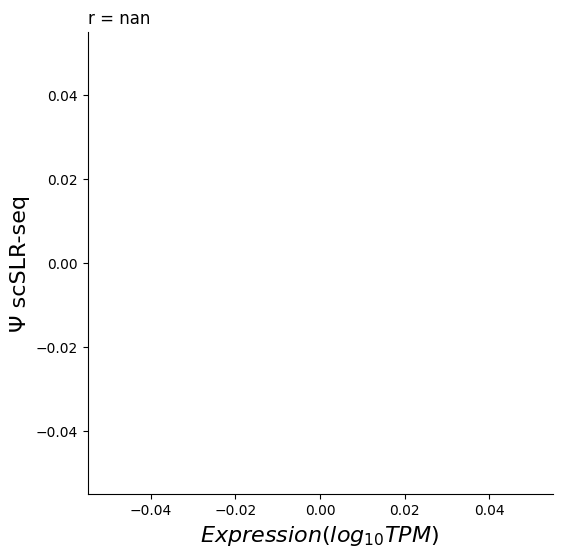

In [59]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.regplot(#data = data,
            x=x,
            y=y,
            scatter_kws={'s':20, 'linewidth':0},
            line_kws={"lw":5, 'color':'black'},
            ax=ax,
            color='grey'
                
               )

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.set_title(f'r = {round(corr,4)}',loc='left')

ax.set_ylabel('Ψ scSLR-seq', fontsize=16)
ax.set_xlabel('$Expression (log_{10} TPM)$', fontsize=16)

#fig.savefig('./plots/PSI_correlation_markers_expression_SLR.pdf')

In [60]:
adata_SS3

AnnData object with n_obs × n_vars = 2854 × 39989
    obs: 'celltype', 'ct1'
    var: 'chromosome', 'start', 'end', 'strand', 'intron_motif', 'annotated', 'total_unique_mapping', 'total_multi_mapping', 'max_overhang', 'n_cells', 'gene_id_start', 'gene_id_end', 'n_genes', 'gene_id', 'gene_name', 'intron_group', 'intron_group_size', 'n_genes_per_intron_group', 'grouping'
    obsm: 'X_umap'
    layers: 'PSI_raw'

In [61]:
adata_SLR

View of AnnData object with n_obs × n_vars = 10173 × 52799
    obs: 'n_counts_mrna', 'n_counts_adts', 'NUM.SNPS', 'NUM.READS', 'DROPLET.TYPE', 'BEST.GUESS', 'percent_mito', 'pool', 'well', 'pool_well', 'batch', 'pool_clust', 'freemux_cluster', 'donor', 'timepoint', 'respiratory_support_D0', 'onset_to_D0_days', 'intubated_days', 'admission_to_discharge', 'D0_to_death', 'race', 'sex', 'ethnicity', 'consent', 'death', 'pulmonary_infection', 'non_pulmonary_infection', 'leiden', 'onset_to_D0_days-as_float', 'D0_to_death-as_float', 'original_leiden', 'ct1', 'ct2', 'ct3', 'RBC', 'WBC_count1', 'WBC_count2', 'WBC_count3', 'Lymphocyte_count', 'Monocyte_count', 'cell_group', 'exclude_restricted', 'IFN_shared_score', 'IFN_beta_score', 'IFN_gamma_score', 'actual_timepoint', 'CT_1', 'CT_2', 'CT_Host', 'dCT_1', 'dCT_2', 'days_from_start', 'COVID_status', 'admission_level', 'respiratory_support', 'NIH_clinical', 'COVID_severity', 'COVID_severity_merged', 'NIH_ordinal'
    var: 'chromosome', 'start', '

In [62]:

SS3= pd.DataFrame()
SLR = pd.DataFrame()

for key in marker_introns.keys():
    
    introns = marker_introns[key]
    introns = [i for i in introns if i in list(set(adata_SS3.var_names) & set(adata_SLR.var_names))]
    
    spec_SS3 = sc.get.obs_df(
        adata_SS3,
        keys=["ct1", *introns],
        layer='PSI_raw')
    
    spec_SS3 = spec_SS3[spec_SS3["ct1"] == key].mean(numeric_only=True)
    
    SS3 = pd.concat([SS3,spec_SS3])
    
    
    
    spec_SLR = sc.get.obs_df(
        adata_SLR,
        keys=["ct1", *introns],
        layer='PSI_raw')
    
    spec_SLR = spec_SLR[spec_SLR["ct1"] == key].mean(numeric_only=True)
    
    SLR = pd.concat([SLR,spec_SLR])

In [63]:
x=SS3.reset_index()[0]
y=SLR.reset_index()[0]

In [64]:
data

,SS2,SLR
LINC01128_chr1:829105-841199_T4,0.275862,0.521739
LINC01128_chr1:829105-847653_T4,0.724138,0.260870
LINC01128_chr1:829105-851926_T4,0.474576,0.217391
UBE2J2_chr1:1257311-1263345_T4,0.970588,0.967742
UBE2J2_chr1:1263387-1273665_T4,0.099010,0.117647
...,...,...
NDUFA1_chrX:119875468-119876513_cDC,0.000000,0.000000
SSR4_chrX:153797533-153797724_cDC,1.000000,1.000000
RPL10_chrX:154398395-154398496_cDC,0.975516,0.989947
RPL10_chrX:154398399-154398496_cDC,0.024484,0.010053


In [65]:
corr = x.corr(y,'spearman')

Text(0.5, 0, 'Ψ scSLR-seq')

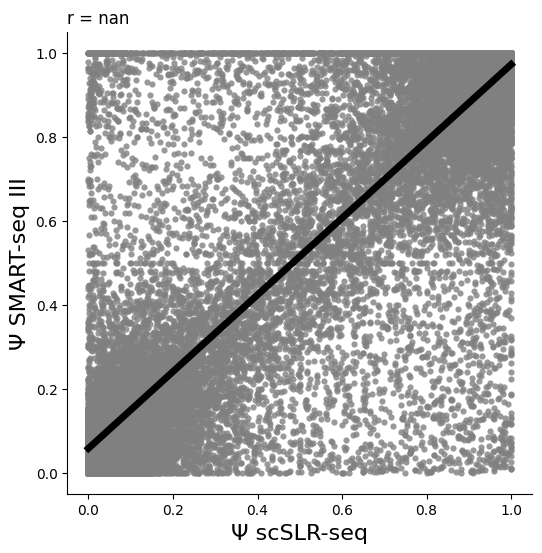

In [66]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.regplot(data = data,
            x='SS2',
            y='SLR',
            scatter_kws={'s':20, 'linewidth':0},
            line_kws={"lw":5, 'color':'black'},
            ax=ax,
            color='grey'
            
                
               )

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.set_title(f'r = {round(corr,4)}',loc='left')

ax.set_ylabel('Ψ SMART-seq III', fontsize=16)
ax.set_xlabel('Ψ scSLR-seq', fontsize=16)

#fig.savefig('./plots/PSI_correlation_markers_PSI_SLR.pdf')

In [67]:
!conda list

# packages in environment at /c4/home/derek/miniconda3/envs/scquint_4:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
aiofiles                  22.1.0             pyhd8ed1ab_0    conda-forge
aiosqlite                 0.18.0             pyhd8ed1ab_0    conda-forge
anndata                   0.8.0                    pypi_0    pypi
anyio                     3.6.2              pyhd8ed1ab_0    conda-forge
appdirs                   1.4.4                    pypi_0    pypi
archspec                  0.2.3              pyhd8ed1ab_0    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py310h5764c6d_3    conda-forge
asttokens                 2.2.1              pyhd8ed1ab_0    conda-forge
attrs                     23.2.0                   pypi_0    pypi
babel